In [1]:
# libreries import

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense, AveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from keras.callbacks import ModelCheckpoint

import os
from scipy import signal
from scipy.io import wavfile
from scipy.fftpack import fft, ifft
from scipy.fftpack import fftfreq
import librosa
from librosa import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import h5py
from IPython.display import Audio

In [2]:
# Loading the audio file to train the network

DI_file = 'data/DI.wav'
AMP_file = 'data/AMP.wav'

project = 'Marshall'

if not os.path.exists('modelMSE/'+project):
    os.makedirs('modelMSE/'+project)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

A model with the same name already exists. Please choose a new name.


In [3]:
in_rate, in_data = wavfile.read(DI_file)
out_rate, out_data = wavfile.read(AMP_file)

C:\Users\ftg\Anaconda3\envs\Python3.6FTG\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


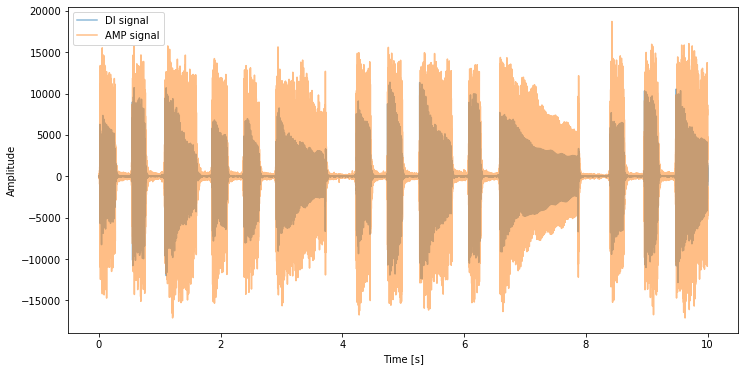

In [4]:
signal_in = in_data[0:int(10* in_rate)]
signal_out = out_data[0:int(10* in_rate)]
Time = np.linspace(0, len(signal_in) / in_rate, num=len(signal_in))

plt.figure(figsize=(12,6))

plt.plot(Time, signal_in, label='DI signal', alpha=0.5)
plt.plot(Time, signal_out, label='AMP signal', alpha=0.5)

plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [5]:
X = in_data.astype(np.float32).flatten()
Y = out_data.astype(np.float32).flatten()

In [6]:
# Mel spectrogram

DI_spect = librosa.feature.melspectrogram(y=X, sr=in_rate, n_fft=2048, hop_length=1024)
DI_spect = librosa.power_to_db(DI_spect, ref=np.max) # Converting to decibals

AMP_spect = librosa.feature.melspectrogram(y=Y, sr=in_rate, n_fft=2048, hop_length=1024)
AMP_spect = librosa.power_to_db(AMP_spect, ref=np.max) # Converting to decibals

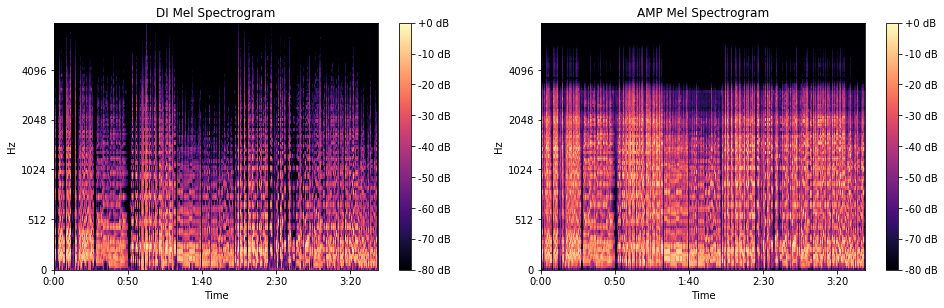

In [7]:
# Plotting the mel spectrogram

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
display.specshow(DI_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('DI Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.subplot(2,2,2)
display.specshow(AMP_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('AMP Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

In [8]:
def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm

In [9]:
X = normalize(X).reshape(len(X),1)  
Y = normalize(Y).reshape(len(Y),1)  

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(Time, X[:len(signal_in)], label="DI signal", alpha=0.5)
plt.plot(Time, Y[:len(signal_in)], label="AMP signal", alpha=0.5)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [10]:
class SequenceDataset(Sequence):
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

In [11]:
# Hyperpameters

learning_rate = 5e-3 
conv1d_strides = 3    
conv1d_filters = 36
hidden_units = 96
batch_size = 1024
epochs = 12

In [12]:
# Split dataset

train_val_set = int(len(X)*0.8)
train_set = int(0.8*train_val_set)

look_back = 150

train_arr = SequenceDataset(X[:train_set], Y[:train_set], look_back, batch_size=batch_size)
val_arr = SequenceDataset(X[train_set:train_val_set], Y[train_set:train_val_set], look_back, batch_size=batch_size)

In [13]:
X.shape, train_arr.x.shape, val_arr.x.shape

((9662209, 1), (6183813, 1), (1545954, 1))

## Model

In [ ]:
clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, 12, strides=1, padding='same', dilation_rate=2, input_shape=(look_back,1)))
model.add(AveragePooling1D(pool_size=2))
model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation='relu', padding='same'))
model.add(LSTM(hidden_units, dropout=0.4, recurrent_dropout=0.2,))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
model.summary()

In [ ]:
path_history='modelMSE/'+project+'/'+'history.xlsx'
my_checkpoint = [
    ModelCheckpoint(filepath = path_history, monitor='val_loss', 
                    verbose=0, save_best_only=True, save_weights_only=False, 
                    mode='auto', save_freq='epoch')
]

my_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

pd.DataFrame(model.fit(train_arr, validation_data=val_arr, epochs=epochs, shuffle=True, callbacks=[my_callback]).history).to_excel(path_history)    
model.save('modelMSE/'+project+'/'+project+'.h5')

In [ ]:
X_test = X[int(len(X)*0.8):]
Y_test = Y[int(len(X)*0.8):]

test_arr = SequenceDataset(X_test, Y_test, look_back, batch_size=batch_size)

In [ ]:
mse_prediction = model.predict(test_arr)

In [ ]:
def save_wav(name, data):
    wavfile.write(name, 44100, data.flatten().astype(np.float32))

In [ ]:
save_wav('modelMSE/'+project+'/y_pred.wav', mse_prediction)
save_wav('modelMSE/'+project+'/x_test.wav', X_test)
save_wav('modelMSE/'+project+'/y_test.wav', Y_test)

## Results

In [ ]:
MSE_rate, MSE_data = wavfile.read('modelMSE/Marshall/y_pred.wav')

DI_rate, DI_data = wavfile.read('modelHUBER/Marshall/x_test.wav')
AMP_rate, AMP_data = wavfile.read('modelHUBER/Marshall/y_test.wav')

In [ ]:
Time = np.linspace(0, len(DI_data[:int(10* DI_rate)]) / DI_rate, num=len(DI_data[:int(10* DI_rate)]))

plt.figure(figsize=(12,6))

plt.plot(Time, DI_data[:int(10* DI_rate)], label='DI signal', alpha=0.5)
plt.plot(Time, AMP_data[:int(10* DI_rate)], label='AMP signal', alpha=0.5)
plt.plot(Time, MSE_data[:int(10* DI_rate)], label='MSE signal', alpha=0.5)

plt.legend(loc=3)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("MSE")
plt.show()

In [ ]:
# Mel spectrogram

DI = DI_data.astype(np.float32).flatten()
DI_spect = librosa.feature.melspectrogram(y=DI, sr=DI_rate, n_fft=2048, hop_length=1024)
DI_spect = librosa.power_to_db(DI_spect, ref=np.max) # Converting to decibals

AMP = AMP_data.astype(np.float32).flatten()
AMP_spect = librosa.feature.melspectrogram(y=AMP, sr=DI_rate, n_fft=2048, hop_length=1024)
AMP_spect = librosa.power_to_db(AMP_spect, ref=np.max) # Converting to decibals


MSE = MSE_data.astype(np.float32).flatten()
MSE_spect = librosa.feature.melspectrogram(y=MSE, sr=DI_rate, n_fft=2048, hop_length=1024)
MSE_spect = librosa.power_to_db(MSE_spect, ref=np.max) # Converting to decibals

In [ ]:
# Plotting the mel spectrogram

plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
display.specshow(DI_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('DI Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.subplot(2,2,2)
display.specshow(AMP_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('AMP Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.subplot(2,2,3)
display.specshow(MSE_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('MSE Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.tight_layout()

In [ ]:
# DI audio
Audio('modelMSE/marshall/x_test.wav')

In [ ]:
# AMP audio
Audio('modelMSE/marshall/y_test.wav')

In [ ]:
# MSE audio
Audio('modelMSE/marshall/y_pred.wav')

## Trying a Low-Pass Filter

In [ ]:
cut_off = 7800

In [ ]:
# Filtering the MSE signal


# FFT the signal
MSE_fft = fft(MSE_data)
# copy the FFT results
MSE_fft_filtered = MSE_fft.copy()

# obtain the frequencies using scipy function
MSE_freq = fftfreq(len(MSE_data), d=1./DI_rate)


# low-pass filter by assign zeros to the 
# FFT amplitudes where the absolute 
# frequencies higher than the cut-off 
MSE_fft_filtered[np.abs(MSE_freq) > cut_off] = 0

# get the filtered signal in time domain
MSE_filtered = ifft(MSE_fft_filtered)

In [ ]:
MSE_flt = MSE_filtered.astype('float32')
MSE_flt_spect = librosa.feature.melspectrogram(y=MSE_flt, sr=DI_rate, n_fft=2048, hop_length=1024)
MSE_flt_spect = librosa.power_to_db(MSE_flt_spect, ref=np.max) # Converting to decibals

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,2,1)
display.specshow(DI_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('DI Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.subplot(2,2,2)
display.specshow(AMP_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('AMP Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.subplot(2,2,3)
librosa.display.specshow(MSE_flt_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('MSE Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

plt.tight_layout()

In [ ]:
save_wav('modelMSE/Marshall/y_flt.wav', MSE_flt)

In [ ]:
# AMP audio
Audio('modelHUBER/Marshall/y_test.wav')

In [ ]:
# MSE audio
Audio('modelMSE/Marshall/y_flt.wav')